In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, \
ExtraTreesClassifier, VotingClassifier, StackingRegressor
from sklearn.metrics import plot_confusion_matrix, recall_score,\
    accuracy_score, precision_score, f1_score, roc_auc_score, plot_roc_curve
from sklearn.dummy import DummyClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

from model import *
import pickle
import warnings

The model library was taken from Flatiron's Workflow with pipelines lecture. Adjustments and addition of a method was added into the model.py

In [2]:
df = pd.read_csv('./data/training_set_features.csv')
df2 = pd.read_csv('./data/training_set_labels.csv')

A test set_feature was provided as well but unfortunately the set_labels that contain the target is with-held for the DataDriven competition. As such for the purposes of model testing, a train-test split will be performed on the training data provided. 

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,1.0,1.0,5.0,2.0,2.0,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN
26703,26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,4.0,2.0,2.0,5.0,1.0,1.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea
26704,26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,4.0,4.0,2.0,5.0,4.0,2.0,55 - 64 Years,Some College,White,Female,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN
26705,26705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,2.0,2.0,1.0,2.0,18 - 34 Years,Some College,Hispanic,Female,"<= $75,000, Above Poverty",Married,Rent,Employed,lrircsnp,Non-MSA,1.0,0.0,fcxhlnwr,haliazsg


In [5]:
df2

,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,0,0
1,1,0,1
2,2,0,0
3,3,0,1
4,4,0,0
...,...,...,...
26702,26702,0,0
26703,26703,0,0
26704,26704,0,1
26705,26705,0,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [7]:
df.education.value_counts()

College Graduate    10097
Some College         7043
12 Years             5797
< 12 Years           2363
Name: education, dtype: int64

In [8]:
df.employment_status.value_counts()

Employed              13560
Not in Labor Force    10231
Unemployed             1453
Name: employment_status, dtype: int64

This makes sense as to why there would be so many missing values for the columns `employment_industry` and `employment_occupation`.

In [9]:
df.health_insurance.value_counts()

1.0    12697
0.0     1736
Name: health_insurance, dtype: int64

In [10]:
df.race.value_counts()
#Do not want to introduce racial bias into this so we'll be dropping this

White                21222
Black                 2118
Hispanic              1755
Other or Multiple     1612
Name: race, dtype: int64

In [11]:
df.child_under_6_months.value_counts()

0.0    23749
1.0     2138
Name: child_under_6_months, dtype: int64

In [12]:
df.hhs_geo_region.value_counts()

lzgpxyit    4297
fpwskwrf    3265
qufhixun    3102
oxchjgsf    2859
kbazzjca    2858
bhuqouqj    2846
mlyzmhmf    2243
lrircsnp    2078
atmpeygn    2033
dqpwygqj    1126
Name: hhs_geo_region, dtype: int64

**Data is from a 2009 H1N1 Flu survey** 

In [13]:
df.isna().sum().sum()
#too many nulls in general to drop all of them

60762

In [14]:
df2.isna().sum().sum()

0

## Data Cleaning before Train-test split

In [15]:
df3 = pd.concat([df,df2], axis = 1)

In [16]:
df3

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,race,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation,respondent_id,h1n1_vaccine,seasonal_vaccine
0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0,1.0,2.0,2.0,1.0,2.0,55 - 64 Years,< 12 Years,White,Female,Below Poverty,Not Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,0.0,0.0,NaN,NaN,0,0,0
1,1,3.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,5.0,4.0,4.0,4.0,2.0,4.0,35 - 44 Years,12 Years,White,Male,Below Poverty,Not Married,Rent,Employed,bhuqouqj,"MSA, Not Principle City",0.0,0.0,pxcmvdjn,xgwztkwe,1,0,1
2,2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,1.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,2.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,"MSA, Not Principle City",2.0,0.0,rucpziij,xtkaffoo,2,0,0
3,3,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,NaN,3.0,3.0,5.0,5.0,4.0,1.0,65+ Years,12 Years,White,Female,Below Poverty,Not Married,Rent,Not in Labor Force,lrircsnp,"MSA, Principle City",0.0,0.0,NaN,NaN,3,0,1
4,4,2.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,3.0,2.0,3.0,1.0,4.0,45 - 54 Years,Some College,White,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb,4,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26702,26702,2.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,3.0,1.0,1.0,5.0,2.0,2.0,65+ Years,Some College,White,Female,"<= $75,000, Above Poverty",Not Married,Own,Not in Labor Force,qufhixun,Non-MSA,0.0,0.0,NaN,NaN,26702,0,0
26703,26703,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,4.0,2.0,2.0,5.0,1.0,1.0,18 - 34 Years,College Graduate,White,Male,"<= $75,000, Above Poverty",Not Married,Rent,Employed,lzgpxyit,"MSA, Principle City",1.0,0.0,fcxhlnwr,cmhcxjea,26703,0,0
26704,26704,2.0,2.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,4.0,4.0,2.0,5.0,4.0,2.0,55 - 64 Years,Some College,White,Female,NaN,Not Married,Own,NaN,lzgpxyit,"MSA, Not Principle City",0.0,0.0,NaN,NaN,26704,0,1
26705,26705,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,2.0,2.0,1.0,2.0,18 - 34 Years,Some College,Hispanic,Female,"<= $75,000, Above Poverty",Married,Rent,Employed,lrircsnp,Non-MSA,1.0,0.0,fcxhlnwr,haliazsg,26705,0,0


In [17]:
df3.employment_status.value_counts()

Employed              13560
Not in Labor Force    10231
Unemployed             1453
Name: employment_status, dtype: int64

In [18]:
df3.employment_status.isna().sum()

1463

In [19]:
10231 + 1453

11684

In [20]:
df3.employment_industry.isna().sum()

13330

In [21]:
13330 - 11684 #how much nulls should remain

1646

In [22]:
#replacement of some nan bases of whether they were employed or not as it makes sense that they would not have an industy
#or occupation
df3.loc[df3['employment_status'] == "Not in Labor Force", 'employment_industry'] = "not_applicable"
df3.loc[df3['employment_status'] == "Not in Labor Force", 'employment_occupation'] = "not_applicable"

In [23]:
df3.employment_industry.isna().sum()

3099

In [24]:
df3.loc[df3['employment_status'] == "Unemployed", 'employment_industry'] = "not_applicable"
df3.loc[df3['employment_status'] == "Unemployed", 'employment_occupation'] = "not_applicable"

In [25]:
df3.employment_industry.isna().sum()

1646

In [26]:
df3.employment_occupation.value_counts()

not_applicable    11684
xtkaffoo           1778
mxkfnird           1509
emcorrxb           1270
cmhcxjea           1247
xgwztkwe           1082
hfxkjkmi            766
qxajmpny            548
xqwwgdyp            485
kldqjyjy            469
uqqtjvyb            452
tfqavkke            388
ukymxvdu            372
vlluhbov            354
oijqvulv            344
ccgxvspp            341
bxpfxfdn            331
haliazsg            296
rcertsgn            276
xzmlyyjv            248
dlvbwzss            227
hodpvpew            208
dcjcmpih            148
pvmttkik             98
Name: employment_occupation, dtype: int64

In [27]:
df3.describe()

,respondent_id,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,household_adults,household_children,respondent_id,h1n1_vaccine,seasonal_vaccine
count,26707.000000,26615.000000,26591.000000,26636.000000,26499.000000,26688.000000,26665.000000,26620.00000,26625.000000,26579.000000,24547.000000,24547.000000,25736.000000,25887.000000,25903.000000,14433.00000,26316.000000,26319.000000,26312.000000,26245.000000,26193.000000,26170.000000,26458.000000,26458.000000,26707.000000,26707.000000,26707.000000
mean,13353.000000,1.618486,1.262532,0.048844,0.725612,0.068982,0.825614,0.35864,0.337315,0.677264,0.220312,0.329735,0.283261,0.082590,0.111918,0.87972,3.850623,2.342566,2.357670,4.025986,2.719162,2.118112,0.886499,0.534583,13353.000000,0.212454,0.465608
std,7709.791156,0.910311,0.618149,0.215545,0.446214,0.253429,0.379448,0.47961,0.472802,0.467531,0.414466,0.470126,0.450591,0.275266,0.315271,0.32530,1.007436,1.285539,1.362766,1.086565,1.385055,1.332950,0.753422,0.928173,7709.791156,0.409052,0.498825
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6676.500000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,3.000000,1.000000,1.000000,4.000000,2.000000,1.000000,0.000000,0.000000,6676.500000,0.000000,0.000000
50%,13353.000000,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.00000,4.000000,2.000000,2.000000,4.000000,2.000000,2.000000,1.000000,0.000000,13353.000000,0.000000,0.000000
75%,20029.500000,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.00000,5.000000,4.000000,4.000000,5.000000,4.000000,4.000000,1.000000,1.000000,20029.500000,0.000000,1.000000
max,26706.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,3.000000,26706.000000,1.000000,1.000000


We see that there is of binary or multilabel numericals

In [28]:
df3.h1n1_vaccine.value_counts()

0    21033
1     5674
Name: h1n1_vaccine, dtype: int64

In [29]:
df3.seasonal_vaccine.value_counts()

0    14272
1    12435
Name: seasonal_vaccine, dtype: int64

In [30]:
X = df3.drop(['respondent_id','race', 'h1n1_vaccine', 'seasonal_vaccine'],
            axis = 1)
y = df3['h1n1_vaccine']

###  Train-test-split 

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 1)

In [32]:
X_train

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
15654,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,5.0,4.0,2.0,4.0,4.0,4.0,65+ Years,< 12 Years,Male,Below Poverty,Married,Own,Not in Labor Force,kbazzjca,Non-MSA,1.0,0.0,not_applicable,not_applicable
14559,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,2.0,4.0,2.0,2.0,45 - 54 Years,12 Years,Male,"<= $75,000, Above Poverty",Married,Rent,Employed,kbazzjca,"MSA, Principle City",0.0,0.0,pxcmvdjn,xqwwgdyp
13752,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,4.0,2.0,1.0,5.0,5.0,1.0,65+ Years,Some College,Male,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,qufhixun,Non-MSA,1.0,0.0,not_applicable,not_applicable
21985,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,1.0,65+ Years,< 12 Years,Female,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,1.0,0.0,not_applicable,not_applicable
18196,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,5.0,2.0,2.0,5.0,2.0,2.0,65+ Years,12 Years,Male,"<= $75,000, Above Poverty",Married,Rent,Not in Labor Force,fpwskwrf,Non-MSA,1.0,0.0,not_applicable,not_applicable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10955,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,1.0,2.0,1.0,1.0,18 - 34 Years,Some College,Female,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,lrircsnp,"MSA, Not Principle City",1.0,3.0,not_applicable,not_applicable
17289,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,5.0,3.0,4.0,4.0,2.0,2.0,35 - 44 Years,College Graduate,Female,"<= $75,000, Above Poverty",NaN,Own,Employed,dqpwygqj,"MSA, Not Principle City",0.0,1.0,pxcmvdjn,xgwztkwe
5192,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,3.0,2.0,4.0,5.0,4.0,4.0,65+ Years,College Graduate,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb
12172,3.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,5.0,4.0,1.0,5.0,4.0,1.0,55 - 64 Years,Some College,Female,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,Non-MSA,0.0,0.0,atmlpfrs,xqwwgdyp


In [33]:
train_df = pd.concat([X_train,y_train], axis =1)

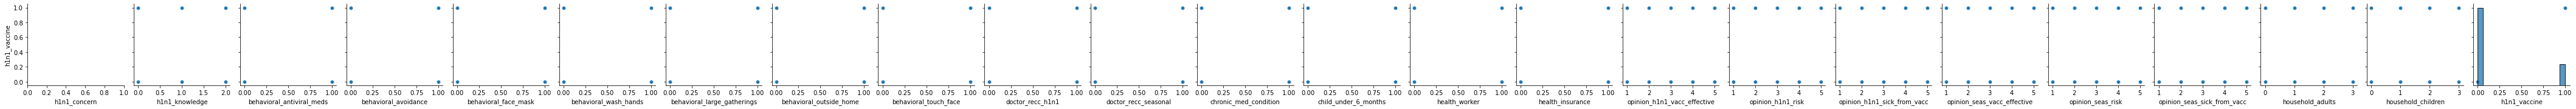

In [34]:
sns.pairplot(train_df, y_vars= 'h1n1_vaccine') #graph makes sense looking at the dictionary for the columns

##### Preprocessing and Transformation

In [35]:
y_train.value_counts(normalize = True)

0    0.787319
1    0.212681
Name: h1n1_vaccine, dtype: float64

Slight Class imbalance where we can SMOTE if we want to. We will SMOTE to .35 to ensure that our data is closer to even split in terms of our target classes.

In [36]:
def get_feature_names(column_transformer):
    """Get feature names from all transformers.
    Returns
    -------
    feature_names : list of strings
        Names of the features produced by transform.
    """
    # Remove the internal helper function
    #check_is_fitted(column_transformer)
    
    # Turn loopkup into function for better handling with pipeline later
    def get_names(trans):
        # >> Original get_feature_names() method
        if trans == 'drop' or (
                hasattr(column, '__len__') and not len(column)):
            return []
        if trans == 'passthrough':
            if hasattr(column_transformer, '_df_columns'):
                if ((not isinstance(column, slice))
                        and all(isinstance(col, str) for col in column)):
                    return column
                else:
                    return column_transformer._df_columns[column]
            else:
                indices = np.arange(column_transformer._n_features)
                return ['x%d' % i for i in indices[column]]
        if not hasattr(trans, 'get_feature_names'):
        # >>> Change: Return input column names if no method avaiable
            # Turn error into a warning
            warnings.warn("Transformer %s (type %s) does not "
                                 "provide get_feature_names. "
                                 "Will return input column names if available"
                                 % (str(name), type(trans).__name__))
            # For transformers without a get_features_names method, use the input
            # names to the column transformer
            if column is None:
                return []
            else:
                return [name + "__" + f for f in column]

        return [name + "__" + f for f in trans.get_feature_names()]
    
    ### Start of processing
    feature_names = []
    
    # Allow transformers to be pipelines. Pipeline steps are named differently, so preprocessing is needed
    if type(column_transformer) == Pipeline:
        l_transformers = [(name, trans, None, None) for step, name, trans in column_transformer._iter()]
    else:
        # For column transformers, follow the original method
        l_transformers = list(column_transformer._iter(fitted=True))
    
    
    for name, trans, column, _ in l_transformers: 
        if type(trans) == Pipeline:
            # Recursive call on pipeline
            _names = get_feature_names(trans)
            # if pipeline has no transformer that returns names
            if len(_names)==0:
                _names = [name + "__" + f for f in column]
            feature_names.extend(_names)
        else:
            feature_names.extend(get_names(trans))
    
    return feature_names

In [37]:
numeric = ['h1n1_concern', 'h1n1_knowledge', 'opinion_h1n1_vacc_effective',
                  'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc',
                  'opinion_seas_vacc_effective', 'opinion_seas_risk',
                  'opinion_seas_sick_from_vacc']

cat_cols = ['behavioral_antiviral_meds', 'behavioral_avoidance',
           'behavioral_face_mask','behavioral_wash_hands',
           'behavioral_large_gatherings', 'behavioral_outside_home',
           'behavioral_touch_face', 'doctor_recc_h1n1',
           'doctor_recc_seasonal', 'chronic_med_condition',
           'child_under_6_months', 'health_worker',
           'health_insurance', 'sex', 'income_poverty',
           'marital_status', 'rent_or_own', 'employment_status',
           'hhs_geo_region', 'census_msa', 'household_adults',
           'household_children', 'employment_industry', 'employment_occupation', 'age_group', 'education']

cat_pipe = Pipeline(steps=[('cat_impute', SimpleImputer(strategy='most_frequent')),
                              ('ohe', OneHotEncoder(sparse=False, handle_unknown='ignore'))])
scale_pipe = Pipeline(steps=[('scale_impute', SimpleImputer(strategy='most_frequent')),
                              ('scale', StandardScaler())])

In [38]:
ct = ColumnTransformer(transformers=[
    ('cat', cat_pipe, cat_cols),
    ('scale', scale_pipe, numeric)
])

In [39]:
#for our simple model
ct_no_cat = ColumnTransformer(transformers=[
    ('scale', scale_pipe, numeric)
])

In [43]:
# def print_summary(model, X, y):
#         roc = plot_roc_curve(model, X ,y);
#         cm = plot_confusion_matrix(model, X, y);
#         preds = model.predict(X)
#         f1_ = f1_score(y, preds)

#         print(cm, roc, f' \n  f1_score is {f1_}')

#### Dummy Regressor for train and test

In [40]:
dummy_pipe = ImPipeline(steps=[
    ('ct', ct),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
    ('dummy', DummyClassifier(strategy='most_frequent'))
]).fit(X_train, y_train)

In [41]:
dummy_results = ModelWithCV(dummy_pipe, 'dummy', X_train, y_train)

78.8% accurate.

 
  f1_score is 0.0 CV Results for `dummy` model:
            0.78732 ± 0.00000 accuracy
         <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x000002446C78F700> <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x00000244462CDB80>


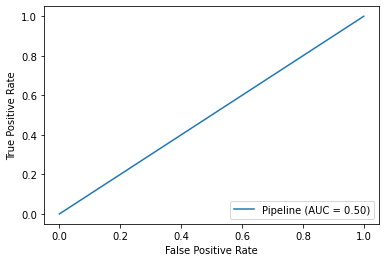

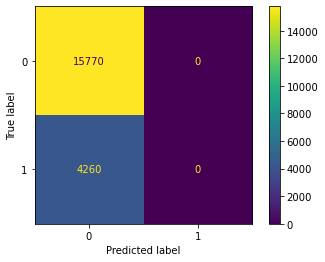

In [42]:
#plot_confusion_matrix(dummy_pipe, X_train, y_train);
dummy_results.print_summary()

#### simple models

Using all our numerical columns as our baseline

In [146]:
X_simple = X_train[numeric]
y_simple = y_train

In [147]:
X_simple

,h1n1_concern,h1n1_knowledge,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc
15654,3.0,0.0,5.0,4.0,2.0,4.0,4.0,4.0
14559,2.0,1.0,4.0,4.0,2.0,4.0,2.0,2.0
13752,1.0,1.0,4.0,2.0,1.0,5.0,5.0,1.0
21985,1.0,1.0,3.0,1.0,1.0,4.0,1.0,1.0
18196,1.0,1.0,5.0,2.0,2.0,5.0,2.0,2.0
...,...,...,...,...,...,...,...,...
10955,1.0,2.0,4.0,1.0,1.0,2.0,1.0,1.0
17289,3.0,1.0,5.0,3.0,4.0,4.0,2.0,2.0
5192,2.0,2.0,3.0,2.0,4.0,5.0,4.0,4.0
12172,3.0,2.0,5.0,4.0,1.0,5.0,4.0,1.0


In [148]:
X_simple.columns == numeric

array([ True,  True,  True,  True,  True,  True,  True,  True])

In [149]:
X_simple_pipe = ImPipeline(steps = [
    ('ct', ct_no_cat),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
    ('logreg', LogisticRegression(random_state=1))
]).fit(X_simple,y_simple)

In [150]:
simple_log = ModelWithCV(X_simple_pipe, 'logreg', X_simple, y_simple, cv_now = True)

In [151]:
log_score = simple_log.cv_mean

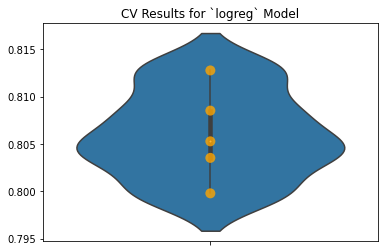

In [152]:
fig, ax = plt.subplots()

ax = simple_log.plot_cv(ax)

 
  f1_score is 0.42861356932153394 CV Results for `logreg` model:
            0.80599 ± 0.00441 accuracy
         <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x0000019C77957CD0> <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x0000019C774C7D00>


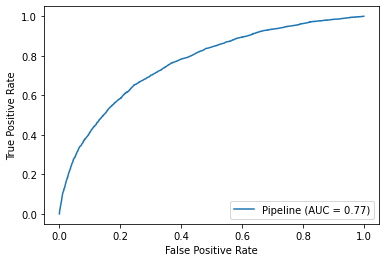

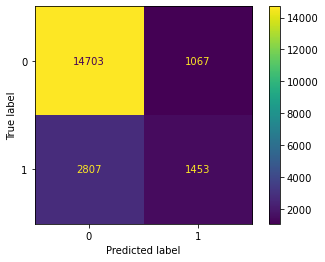

In [153]:
#plot_confusion_matrix(X_simple_pipe, X_simple, y_simple);
simple_log.print_summary()

f1, auc score and the accuracy is better than dummy.

#### simple svc

In [154]:
#using kernel = linear as it needs to be this to get features
svc2_pipe = ImPipeline(steps = [
    ('ct', ct_no_cat),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)), 
    ('svc2', SVC(random_state=1, kernel='linear'))]).fit(X_simple,y_simple)

In [155]:
sv2_results = ModelWithCV(svc2_pipe, 'svc2', X_simple, y_simple, cv_now = True)

In [156]:
sv2_score = sv2_results.cv_mean

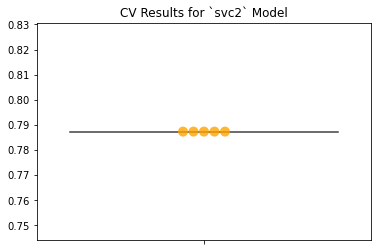

In [157]:
fig, ax = plt.subplots()

ax = sv2_results.plot_cv(ax)

 
  f1_score is 0.0 CV Results for `svc2` model:
            0.78732 ± 0.00000 accuracy
         <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x0000019C0BEB8A30> <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x0000019C77C0B340>


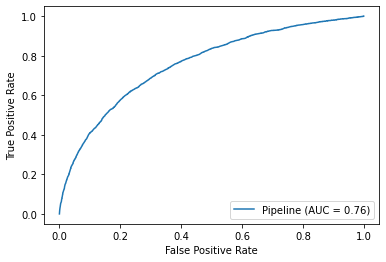

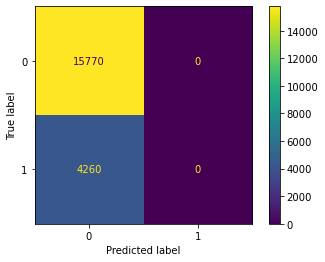

In [158]:
sv2_results.print_summary()

This has a better auc score but the accuracy and f1 is the same as dummy, so the default kernel for SVC is not good for this.

#### simple KNN 

In [159]:
knn_p = ImPipeline(steps = [
    ('ct', ct_no_cat),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
    ('knn', KNeighborsClassifier())]).fit(X_simple,y_simple)

In [160]:
#knn = KNeighborsClassifier().fit(X_simple_trans, y_simple)

In [161]:
knn_result = ModelWithCV(knn_p, 'knn', X_simple, y_simple, cv_now = True)

In [162]:
knn_score = knn_result.cv_mean

 
  f1_score is 0.5331724969843185 CV Results for `knn` model:
            0.77589 ± 0.00337 accuracy
         <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x0000019C73C21070> <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x0000019C08E77370>


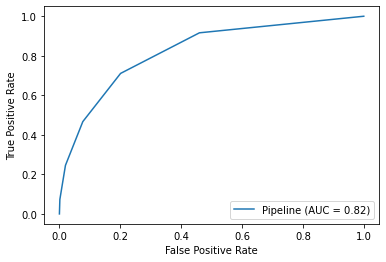

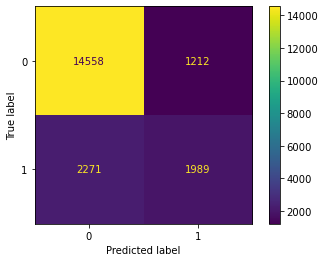

In [163]:
knn_result.print_summary()

lower accuracy but better f1 and auc score

#### simple dtree

In [164]:
dtree_pipe = ImPipeline(steps = [
    ('ct', ct_no_cat),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
    ('knn', DecisionTreeClassifier(random_state=1))]).fit(X_simple,y_simple)

In [165]:
dtree_result = ModelWithCV(dtree_pipe, 'dt', X_simple, y_simple, cv_now = True)

In [166]:
dtree_score = dtree_result.cv_mean

 
  f1_score is 0.6371456776195176 CV Results for `dt` model:
            0.76715 ± 0.00223 accuracy
         <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x0000019C08E95E80> <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x0000019C08E77340>


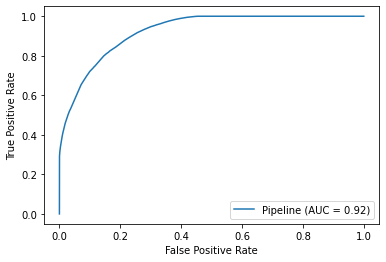

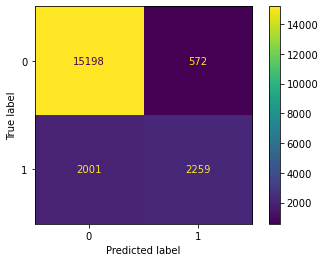

In [167]:
dtree_result.print_summary()

The decision tree has a lower accuracy but higher auc, and f1 score compared to the dummy.

##### let's put multiple default models in voting!

In [168]:
voting = VotingClassifier(estimators= [
    ('lr', X_simple_pipe),
    ('knn', knn_p),
    ('dt', dtree_pipe)],
).fit(X_simple,y_simple)

In [169]:
voting_result = ModelWithCV(voting, 'voting', X_simple, y_simple, cv_now = True)

In [170]:
voting_score = voting_result.cv_mean

In [171]:
voting_score

0.7941088367448826

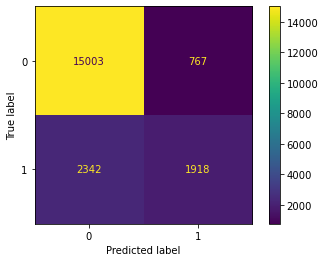

In [172]:
plot_confusion_matrix(voting, X_simple, y_simple);

In [173]:
preds = voting.predict(X_simple)

f1_score(y_simple, preds)

0.5523398128149748

we will use all our features this time around and scale/transofrm it out to see if it does any better in predicting.

### Addition of more features

we will use all our features this time around and scale/transofrm it out to see if it does any better in predicting.

###### logistic regression

In [174]:
#no grid search performed
logreg_pipe = ImPipeline(steps = [
    ('ct', ct),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
    ('logreg', LogisticRegression(random_state=1))
]).fit(X_train,y_train)

C:\Users\xiao\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [175]:
logreg_result = ModelWithCV(logreg_pipe,'log_reg',X_train,y_train)

C:\Users\xiao\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\xiao\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#l

 
  f1_score is 0.5581950895819509 CV Results for `log_reg` model:
            0.83190 ± 0.00511 accuracy
         <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x0000019C08572400> <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x0000019C7329D130>


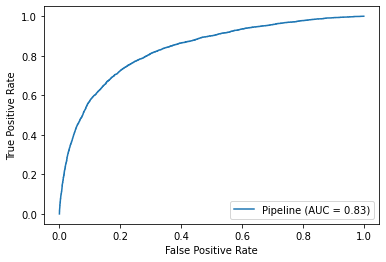

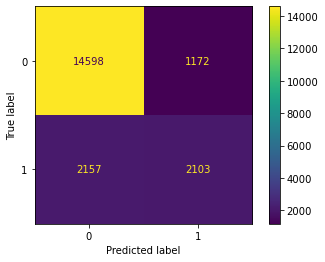

In [176]:
logreg_result.print_summary()

When including all our features the acurracy increases from 78-79% to about 83%.

###### knn model

In [177]:
# knn_pipe = ImPipeline(steps = [
#     ('ct', ct),
#     ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
#     ('knn', KNeighborsClassifier())
# ]).fit(X_train,y_train)

In [178]:
# knn_pickle = 'knn_pipe.sav'
# pickle.dump(knn_pipe, open(knn_pickle, 'wb'))

In [179]:
knn_pipe = pickle.load(open('knn_pipe.sav', 'rb'))

In [180]:
knn1_results = ModelWithCV(knn_pipe,'knn',X_train,y_train)

 
  f1_score is 0.6570865685479198 CV Results for `knn` model:
            0.77983 ± 0.00276 accuracy
         <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x0000019C77955DF0> <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x0000019C0BDF3C10>


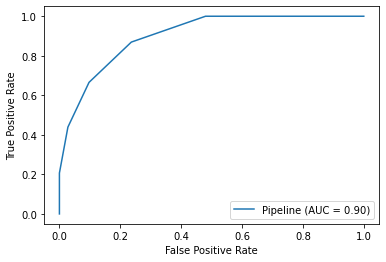

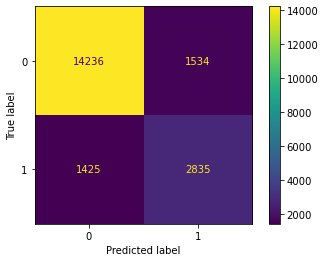

In [181]:
knn1_results.print_summary()

###### Decision Tree model

In [182]:
# dt_pipe = ImPipeline(steps = [
#     ('ct', ct),
#     ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
#     ('dt', DecisionTreeClassifier(random_state=1))
# ]).fit(X_train,y_train)

In [183]:
# dt_pickle = 'dt_pipe.sav'
# pickle.dump(dt_pipe, open(dt_pickle, 'wb'))

In [184]:
dt_pipe = pickle.load(open('dt_pipe.sav', 'rb'))

In [185]:
dt_results = ModelWithCV(dt_pipe,'dt',X_train,y_train) #0.7581627558662006

 
  f1_score is 1.0 CV Results for `dt` model:
            0.75816 ± 0.00335 accuracy
         <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x0000019C734C1640> <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x0000019C73515850>


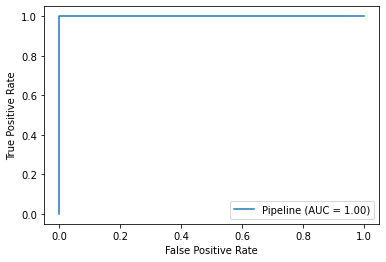

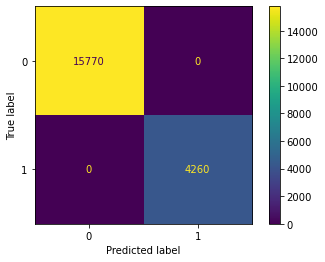

In [186]:
dt_results.print_summary()

Overfit model?

###### SVC model

In [187]:
# svm_pipe = ImPipeline(steps = [
#     ('ct', ct),
#     ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
#     ('svm', SVC(random_state=1))
# ]).fit(X_train,y_train)

In [188]:
# svm_pickle = 'svm_pipe.sav'
# pickle.dump(svm_pipe, open(svm_pickle, 'wb'))

In [189]:
svm_pipe = pickle.load(open('svm_pipe.sav', 'rb'))

In [190]:
#takes a long time to load
cv_svm = ModelWithCV(svm_pipe,'svm',X_train,y_train)

 
  f1_score is 0.6217757263100733 CV Results for `svm` model:
            0.83600 ± 0.00409 accuracy
         <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x0000019C7796CF40> <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x0000019C0BDF7DF0>


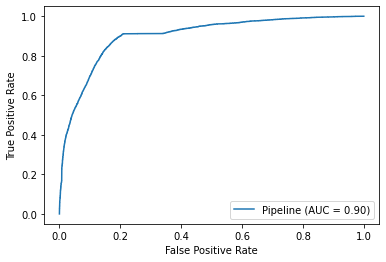

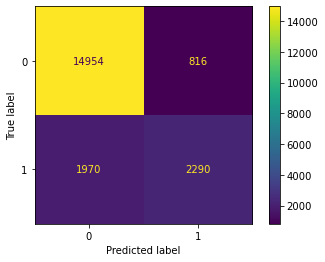

In [191]:
cv_svm.print_summary()

In [192]:
svm1_pipe = ImPipeline(steps = [
     ('ct', ct),
     ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
     ('svm', SVC(random_state=1, kernel='linear'))
 ]).fit(X_train,y_train)

In [193]:
cv_svm1 = ModelWithCV(svm1_pipe,'svm',X_train,y_train)

 
  f1_score is 0.5516100292732595 CV Results for `svm` model:
            0.82426 ± 0.00813 accuracy
         <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x0000019C77967EE0> <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x0000019C0BDD7D60>


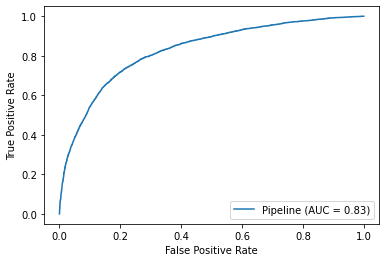

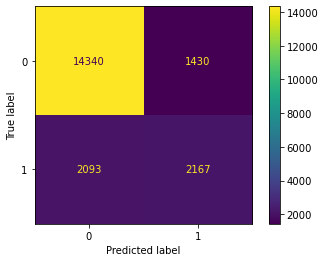

In [194]:
cv_svm1.print_summary()

In [195]:
#cv_svm = 0.8356465302046929

##### voting model

In [196]:
#found the parameters for the logistic regression so we'll input this in our voting classifer
# logreg2_pipe = ImPipeline(steps = [
#     ('ct', ct),
#     ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
#     ('logreg', LogisticRegression(random_state=1,C=1, max_iter=50, penalty = 'l1', solver='saga' ))
# ]).fit(X_train,y_train)

In [205]:
# voting_complex = VotingClassifier(estimators= [
#      ('lr', logreg_pipe),
#      ('knn', knn_pipe),
#      ('dt', dt_pipe)
#  ], n_jobs=-1).fit(X_train,y_train)

In [206]:
# voting_pickle = 'voting.sav'
# pickle.dump(voting_complex, open(voting_pickle, 'wb'))

In [207]:
voting_complex = pickle.load(open('voting.sav', 'rb'))

In [208]:
voting_complex_results = ModelWithCV(voting_complex, 'voting', X_train, y_train) # 0.834648027958063

In [209]:
#voting_complex_results.print_summary()

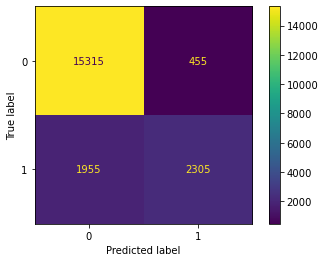

In [210]:
plot_confusion_matrix(voting_complex, X_train, y_train)

In [211]:
preds = voting_complex.predict(X_train)

f1_score(y_train, preds)

0.6566951566951568

In [212]:
voting_complex_results.cv_mean

0.8341487768347479

##### let's try out bagging instead 

In [213]:
#bagging- no need to pickle as it doesn't take too long to run
bagdt_pipe = ImPipeline(steps=[
    ('ct', ct),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
    ('bag', BaggingClassifier(random_state= 1))
]).fit(X_train, y_train)

In [214]:
bagdt_result = ModelWithCV(bagdt_pipe, 'bagging', X_train, y_train)

 
  f1_score is 0.9587841945288754 CV Results for `bagging` model:
            0.81957 ± 0.00470 accuracy
         <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x0000019C0BB9D370> <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x0000019C09D348B0>


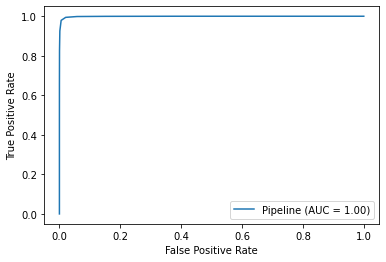

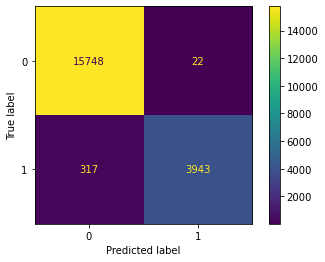

In [215]:
bagdt_result.print_summary()

Better than the decision tree by itself but it's super overfit?.

##### random forest

In [216]:
rf_pipe = ImPipeline(steps=[
    ('ct', ct),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
    ('rf', RandomForestClassifier(n_jobs=-1))
]).fit(X_train, y_train)

In [217]:
rf_result = ModelWithCV(rf_pipe, 'bagging', X_train, y_train)

 
  f1_score is 1.0 CV Results for `bagging` model:
            0.83345 ± 0.00172 accuracy
         <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x0000019C0B83FB20> <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x0000019C09CC9850>


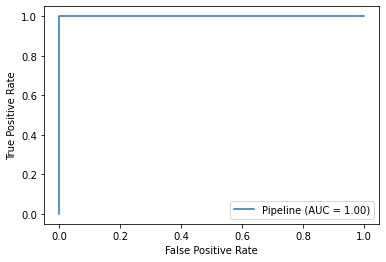

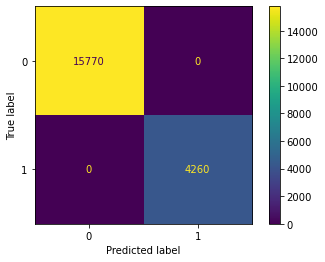

In [218]:
rf_result.print_summary()

### Model tuning

##### gridsearch bagging 

In [219]:
# bagdt_pipe = ImPipeline(steps=[
#      ('ct', ct),
#      ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
#      ('bag', BaggingClassifier(random_state= 1))
#  ]).fit(X_train, y_train)

In [220]:
#  bag_params = {
#      'bag__n_estimators' : [10,100,1000],
#      'bag__max_features' : [5,10,15,20],
#  }

In [221]:
# bag_grid = GridSearchCV(estimator=bagdt_pipe, param_grid=bag_params, n_jobs=-1).fit(X_train,y_train)

In [222]:
# bag_pickle = 'bag_gridsearch.sav'
# pickle.dump(bag_grid, open(bag_pickle, 'wb'))

In [223]:
bag_grid = pickle.load(open('bag_gridsearch.sav', 'rb'))

In [224]:
bag_grid.best_params_

{'bag__max_features': 20, 'bag__n_estimators': 1000}

In [225]:
bag_tune = ModelWithCV(bag_grid.best_estimator_,'bag_tune', X_train, y_train)

 
  f1_score is 0.43731671554252194 CV Results for `bag_tune` model:
            0.79770 ± 0.00158 accuracy
         <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x0000019C09EAA2B0> <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x0000019C734D7340>


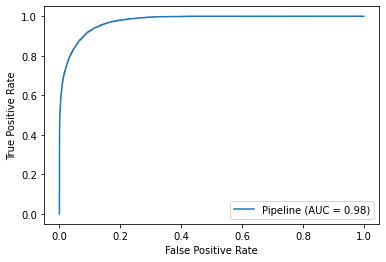

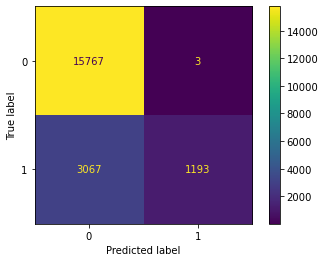

In [226]:
bag_tune.print_summary()

##### grid search random forest

In [239]:
 rf_pipe = ImPipeline(steps=[
     ('ct', ct),
     ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
     ('rf', RandomForestClassifier(n_jobs=-1))
 ]).fit(X_train, y_train)

In [240]:
 rf_params = {
     'rf__n_estimators' : [10 ,100,200],
     'rf__criterion' : ['gini', 'entropy'],
     'rf__max_depth' : [5,10,20,25],
     'rf__min_samples_split' : [100,500,1000]
 }

In [241]:
 rf_grid = GridSearchCV(estimator=rf_pipe, param_grid=rf_params, n_jobs=-1,verbose=3).fit(X_train,y_train)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.7min finished


In [242]:
rf_pickle = 'rf_gridsearch.sav'
pickle.dump(rf_grid, open(rf_pickle, 'wb'))

In [243]:
rf_grid = pickle.load(open('rf_gridsearch.sav', 'rb'))

In [244]:
rf_grid.best_score_

0.8333999001497754

In [245]:
rf_grid.best_params_

{'rf__criterion': 'gini',
 'rf__max_depth': 25,
 'rf__min_samples_split': 100,
 'rf__n_estimators': 100}

In [246]:
rf_tune = ModelWithCV(rf_grid.best_estimator_,'bag_tune', X_train, y_train)

 
  f1_score is 0.570295908254283 CV Results for `bag_tune` model:
            0.83305 ± 0.00404 accuracy
         <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x0000019C775FF7C0> <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x0000019C0867A040>


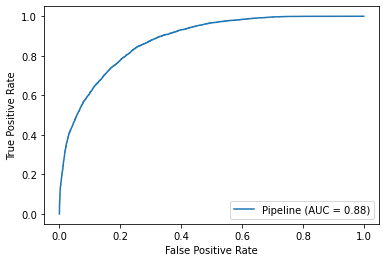

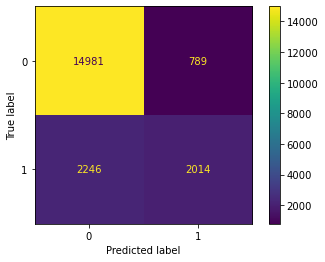

In [247]:
rf_tune.print_summary()

**A SVC gridsearch was not perform due to the big O issue that would be encountered as the fitting time will increase quadratically for the amount of rows**

#### rfe with 60

In [42]:
rf_pipe2 = ImPipeline(steps=[
    ('ct', ct),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
    ('rfe', RFE(RandomForestClassifier(criterion='gini', max_depth=25, min_samples_split=100, n_estimators = 100),
               n_features_to_select= 60)),
    ('rf', RandomForestClassifier(criterion='gini', max_depth=25, min_samples_split=100, n_estimators = 100))
]).fit(X_train, y_train)

In [43]:
rf_pipe2.score(X_train, y_train)

0.8475786320519221

 
  f1_score is 0.5689679514330086 CV Results for `rf_pipe2` model:
            0.83270 ± 0.00473 accuracy
         <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x00000258BBB71160> <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x00000258B8E4AD00>


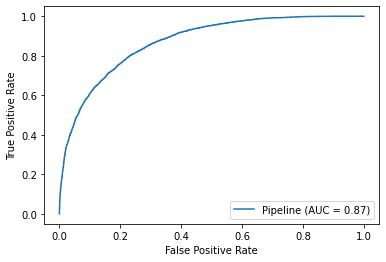

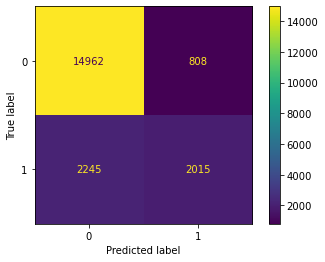

In [44]:
ModelWithCV(rf_pipe2, 'rf_pipe2', X_train, y_train).print_summary()

In [45]:
rf_pipe2.named_steps.rf.feature_importances_

array([0.00287853, 0.00303451, 0.0028319 , 0.00261691, 0.00467208,
       0.00497053, 0.00352422, 0.00400658, 0.00249485, 0.00339857,
       0.14776562, 0.15758414, 0.03016106, 0.03016943, 0.00671099,
       0.00549313, 0.00294643, 0.01955055, 0.0204645 , 0.00365039,
       0.0033166 , 0.003555  , 0.00547227, 0.00300711, 0.00303423,
       0.00323707, 0.00266704, 0.00304625, 0.00300586, 0.00315235,
       0.00298198, 0.00346022, 0.00351984, 0.00205032, 0.00290547,
       0.00436382, 0.00353927, 0.01489328, 0.0068381 , 0.0026351 ,
       0.00341317, 0.0095898 , 0.00689841, 0.00311262, 0.00396641,
       0.0033776 , 0.00408214, 0.00876536, 0.00306606, 0.00381026,
       0.00754407, 0.00364083, 0.01366781, 0.01319088, 0.12341068,
       0.12483172, 0.01094552, 0.05102471, 0.05227782, 0.00977805])

In [46]:
rf_pipe2.named_steps.rfe.support_

array([False,  True,  True,  True, False,  True,  True,  True,  True,
        True, False, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False,  True,  True, False, False,  True,
        True,  True,  True, False, False,  True,  True,  True, False,
        True, False, False,  True, False,  True, False, False,  True,
       False,  True, False,  True,  True,  True, False,  True, False,
       False,  True, False, False, False,  True, False, False, False,
        True,  True, False, False, False, False, False,  True, False,
       False, False, False, False, False, False,  True, False, False,
       False, False,  True,  True, False, False, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False,  True, False,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

In [51]:
features = pd.DataFrame(rf_pipe2.named_steps.rfe.support_.flatten(), index=get_feature_names(ct))

<ipython-input-36-873dfa738c27>:30: UserWarning: Transformer cat_impute (type SimpleImputer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
<ipython-input-36-873dfa738c27>:30: UserWarning: Transformer scale_impute (type SimpleImputer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
<ipython-input-36-873dfa738c27>:30: UserWarning: Transformer scale (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


In [48]:
features

,0
ohe__x0_0.0,False
ohe__x0_1.0,True
ohe__x1_0.0,True
ohe__x1_1.0,True
ohe__x2_0.0,False
...,...
scale__opinion_h1n1_risk,True
scale__opinion_h1n1_sick_from_vacc,True
scale__opinion_seas_vacc_effective,True
scale__opinion_seas_risk,True


In [65]:
features[features[0]== True]

,0
ohe__x0_1.0,True
ohe__x1_0.0,True
ohe__x1_1.0,True
ohe__x2_1.0,True
ohe__x3_0.0,True
ohe__x3_1.0,True
ohe__x4_0.0,True
ohe__x4_1.0,True
ohe__x6_0.0,True
ohe__x6_1.0,True


#### RFE of 100 selection

In [255]:
rf_pipe3 = ImPipeline(steps=[
    ('ct', ct),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
    ('rfe', RFE(RandomForestClassifier(criterion='gini', max_depth=25, min_samples_split=100, n_estimators = 100),
               n_features_to_select= 100)),
    ('rf', RandomForestClassifier(criterion='gini', max_depth=25, min_samples_split=100, n_estimators = 100))
], verbose=True).fit(X_train, y_train)

[Pipeline] ................ (step 1 of 4) Processing ct, total=   2.6s
[Pipeline] ................ (step 2 of 4) Processing sm, total=   2.6s
[Pipeline] ............... (step 3 of 4) Processing rfe, total=  28.7s
[Pipeline] ................ (step 4 of 4) Processing rf, total=   1.2s


[Pipeline] ................ (step 1 of 4) Processing ct, total=   1.9s
[Pipeline] ................ (step 2 of 4) Processing sm, total=   1.5s
[Pipeline] ............... (step 3 of 4) Processing rfe, total=  22.2s
[Pipeline] ................ (step 4 of 4) Processing rf, total=   1.0s
[Pipeline] ................ (step 1 of 4) Processing ct, total=   2.0s
[Pipeline] ................ (step 2 of 4) Processing sm, total=   1.5s
[Pipeline] ............... (step 3 of 4) Processing rfe, total=  23.7s
[Pipeline] ................ (step 4 of 4) Processing rf, total=   1.1s
[Pipeline] ................ (step 1 of 4) Processing ct, total=   2.1s
[Pipeline] ................ (step 2 of 4) Processing sm, total=   1.6s
[Pipeline] ............... (step 3 of 4) Processing rfe, total=  22.6s
[Pipeline] ................ (step 4 of 4) Processing rf, total=   1.0s
[Pipeline] ................ (step 1 of 4) Processing ct, total=   1.9s
[Pipeline] ................ (step 2 of 4) Processing sm, total=   1.5s
[Pipel

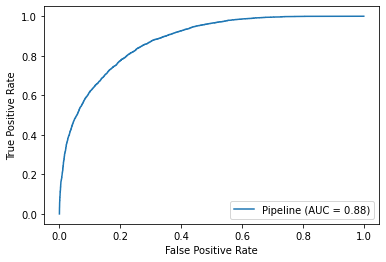

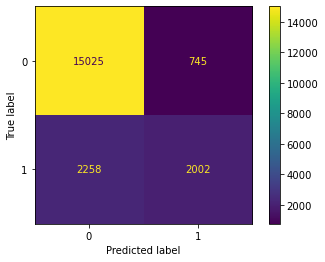

In [256]:
ModelWithCV(rf_pipe3, 'rf_pipe3', X_train, y_train).print_summary()

##### RFE with 25

In [257]:
rf_pipe4 = ImPipeline(steps=[
    ('ct', ct),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
    ('rfe', RFE(RandomForestClassifier(criterion='gini', max_depth=25, min_samples_split=100, n_estimators = 100),
               n_features_to_select= 25)),
    ('rf', RandomForestClassifier(criterion='gini', max_depth=25, min_samples_split=100, n_estimators = 100))
], verbose=True).fit(X_train, y_train)

[Pipeline] ................ (step 1 of 4) Processing ct, total=   2.7s
[Pipeline] ................ (step 2 of 4) Processing sm, total=   2.7s
[Pipeline] ............... (step 3 of 4) Processing rfe, total= 1.7min
[Pipeline] ................ (step 4 of 4) Processing rf, total=   0.8s


[Pipeline] ................ (step 1 of 4) Processing ct, total=   2.2s
[Pipeline] ................ (step 2 of 4) Processing sm, total=   1.5s
[Pipeline] ............... (step 3 of 4) Processing rfe, total= 1.4min
[Pipeline] ................ (step 4 of 4) Processing rf, total=   0.7s
[Pipeline] ................ (step 1 of 4) Processing ct, total=   2.0s
[Pipeline] ................ (step 2 of 4) Processing sm, total=   1.5s
[Pipeline] ............... (step 3 of 4) Processing rfe, total= 1.4min
[Pipeline] ................ (step 4 of 4) Processing rf, total=   0.6s
[Pipeline] ................ (step 1 of 4) Processing ct, total=   2.0s
[Pipeline] ................ (step 2 of 4) Processing sm, total=   1.5s
[Pipeline] ............... (step 3 of 4) Processing rfe, total= 1.3min
[Pipeline] ................ (step 4 of 4) Processing rf, total=   0.7s
[Pipeline] ................ (step 1 of 4) Processing ct, total=   2.0s
[Pipeline] ................ (step 2 of 4) Processing sm, total=   1.5s
[Pipel

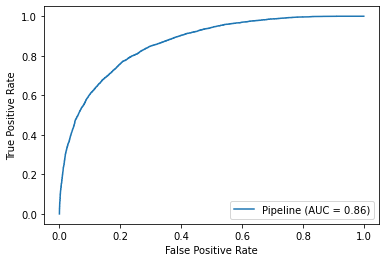

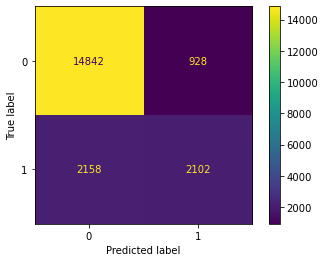

In [258]:
ModelWithCV(rf_pipe4, 'rf_pipe3', X_train, y_train).print_summary()

##### RFE with all features 

In [53]:
rf_pipe5 = ImPipeline(steps=[
    ('ct', ct),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
    ('rfe', RFE(RandomForestClassifier(criterion='gini', max_depth=25, min_samples_split=100, n_estimators = 100),
               n_features_to_select= 122)),
    ('rf', RandomForestClassifier(criterion='gini', max_depth=25, min_samples_split=100, n_estimators = 100))
], verbose=True).fit(X_train, y_train)

[Pipeline] ................ (step 1 of 4) Processing ct, total=   0.8s
[Pipeline] ................ (step 2 of 4) Processing sm, total=   2.8s
[Pipeline] ............... (step 3 of 4) Processing rfe, total=   1.6s
[Pipeline] ................ (step 4 of 4) Processing rf, total=   1.5s


[Pipeline] ................ (step 1 of 4) Processing ct, total=   0.6s
[Pipeline] ................ (step 2 of 4) Processing sm, total=   1.6s
[Pipeline] ............... (step 3 of 4) Processing rfe, total=   1.2s
[Pipeline] ................ (step 4 of 4) Processing rf, total=   1.2s
[Pipeline] ................ (step 1 of 4) Processing ct, total=   0.6s
[Pipeline] ................ (step 2 of 4) Processing sm, total=   1.5s
[Pipeline] ............... (step 3 of 4) Processing rfe, total=   1.1s
[Pipeline] ................ (step 4 of 4) Processing rf, total=   1.1s
[Pipeline] ................ (step 1 of 4) Processing ct, total=   0.6s
[Pipeline] ................ (step 2 of 4) Processing sm, total=   1.5s
[Pipeline] ............... (step 3 of 4) Processing rfe, total=   1.3s
[Pipeline] ................ (step 4 of 4) Processing rf, total=   1.3s
[Pipeline] ................ (step 1 of 4) Processing ct, total=   0.6s
[Pipeline] ................ (step 2 of 4) Processing sm, total=   1.5s
[Pipel

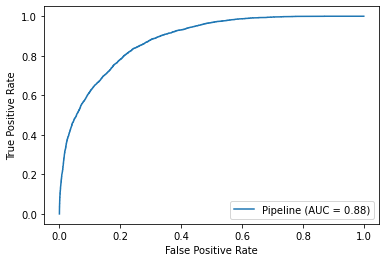

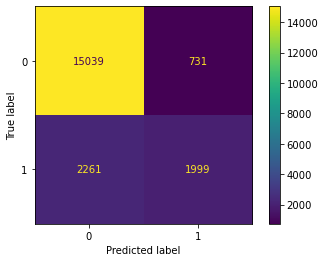

In [54]:
ModelWithCV(rf_pipe5, 'rf_pipe3', X_train, y_train).print_summary()

In [56]:
feature1 = pd.DataFrame(rf_pipe5.named_steps.rf.feature_importances_, index=get_feature_names(ct))

<ipython-input-36-873dfa738c27>:30: UserWarning: Transformer cat_impute (type SimpleImputer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
<ipython-input-36-873dfa738c27>:30: UserWarning: Transformer scale_impute (type SimpleImputer) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "
<ipython-input-36-873dfa738c27>:30: UserWarning: Transformer scale (type StandardScaler) does not provide get_feature_names. Will return input column names if available
  warnings.warn("Transformer %s (type %s) does not "


In [60]:
feature1.sort_values(0, ascending=False)[:10]

,0
ohe__x7_1.0,0.161597
ohe__x7_0.0,0.134653
scale__opinion_h1n1_risk,0.107537
scale__opinion_h1n1_vacc_effective,0.095951
scale__opinion_seas_risk,0.053110
scale__opinion_seas_vacc_effective,0.046358
ohe__x8_1.0,0.029506
ohe__x8_0.0,0.025900
ohe__x11_0.0,0.021765
ohe__x11_1.0,0.016324


In [ ]:
cat_cols = ['behavioral_antiviral_meds', 'behavioral_avoidance',
           'behavioral_face_mask','behavioral_wash_hands',
           'behavioral_large_gatherings', 'behavioral_outside_home',
           'behavioral_touch_face', 'doctor_recc_h1n1',
           'doctor_recc_seasonal', 'chronic_med_condition',
           'child_under_6_months', 'health_worker',
           'health_insurance', 'sex', 'income_poverty',
           'marital_status', 'rent_or_own', 'employment_status',
           'hhs_geo_region', 'census_msa', 'household_adults',
           'household_children', 'employment_industry', 'employment_occupation', 'age_group', 'education']

In [59]:
X_train

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,doctor_recc_seasonal,chronic_med_condition,child_under_6_months,health_worker,health_insurance,opinion_h1n1_vacc_effective,opinion_h1n1_risk,opinion_h1n1_sick_from_vacc,opinion_seas_vacc_effective,opinion_seas_risk,opinion_seas_sick_from_vacc,age_group,education,sex,income_poverty,marital_status,rent_or_own,employment_status,hhs_geo_region,census_msa,household_adults,household_children,employment_industry,employment_occupation
15654,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,5.0,4.0,2.0,4.0,4.0,4.0,65+ Years,< 12 Years,Male,Below Poverty,Married,Own,Not in Labor Force,kbazzjca,Non-MSA,1.0,0.0,not_applicable,not_applicable
14559,2.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,4.0,2.0,4.0,2.0,2.0,45 - 54 Years,12 Years,Male,"<= $75,000, Above Poverty",Married,Rent,Employed,kbazzjca,"MSA, Principle City",0.0,0.0,pxcmvdjn,xqwwgdyp
13752,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,4.0,2.0,1.0,5.0,5.0,1.0,65+ Years,Some College,Male,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,qufhixun,Non-MSA,1.0,0.0,not_applicable,not_applicable
21985,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,0.0,NaN,3.0,1.0,1.0,4.0,1.0,1.0,65+ Years,< 12 Years,Female,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,oxchjgsf,Non-MSA,1.0,0.0,not_applicable,not_applicable
18196,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,5.0,2.0,2.0,5.0,2.0,2.0,65+ Years,12 Years,Male,"<= $75,000, Above Poverty",Married,Rent,Not in Labor Force,fpwskwrf,Non-MSA,1.0,0.0,not_applicable,not_applicable
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10955,1.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,1.0,1.0,2.0,1.0,1.0,18 - 34 Years,Some College,Female,"<= $75,000, Above Poverty",Married,Own,Not in Labor Force,lrircsnp,"MSA, Not Principle City",1.0,3.0,not_applicable,not_applicable
17289,3.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,NaN,5.0,3.0,4.0,4.0,2.0,2.0,35 - 44 Years,College Graduate,Female,"<= $75,000, Above Poverty",NaN,Own,Employed,dqpwygqj,"MSA, Not Principle City",0.0,1.0,pxcmvdjn,xgwztkwe
5192,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,3.0,2.0,4.0,5.0,4.0,4.0,65+ Years,College Graduate,Female,"<= $75,000, Above Poverty",Married,Own,Employed,qufhixun,"MSA, Not Principle City",1.0,0.0,wxleyezf,emcorrxb
12172,3.0,2.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,5.0,4.0,1.0,5.0,4.0,1.0,55 - 64 Years,Some College,Female,"<= $75,000, Above Poverty",Not Married,Own,Employed,qufhixun,Non-MSA,0.0,0.0,atmlpfrs,xqwwgdyp


In [ ]:
#behavioral_touch_face yes/no
# opinion of the risk of h1n1
# h1n1 vaccine effectiveness
#season flu vaccine risk
#season flu vaccine effectiveness
# doc recommendation for the h1n1 vaccine
#child under 6 months

### Final Model Evaluation

In [261]:
rf_pipe2 = ImPipeline(steps=[
    ('ct', ct),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
    ('rfe', RFE(RandomForestClassifier(criterion='gini', max_depth=25, min_samples_split=100, n_estimators = 100),
               n_features_to_select= 60)),
    ('rf', RandomForestClassifier(criterion='gini', max_depth=25, min_samples_split=100, n_estimators = 100))
]).fit(X_train, y_train)

In [262]:
final_model = rf_pipe2

 
  f1_score is 0.5391527599486521 CV Results for `final_model` model:
            0.83885 ± 0.00759 accuracy
         <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x0000019C7790D1C0> <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x0000019C158E0280>


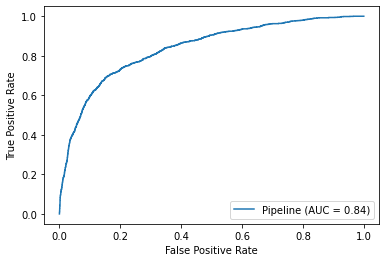

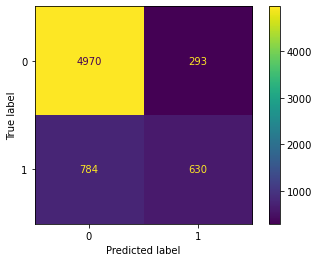

In [263]:
ModelWithCV(final_model, 'final_model', X_test, y_test).print_summary()

In [264]:
svm_pipe = ImPipeline(steps = [
    ('ct', ct),
    ('sm', SMOTE(sampling_strategy= 0.35, random_state=1)),
    ('svm', SVC(random_state=1))
]).fit(X_train,y_train)

 
  f1_score is 0.5655058043117744 CV Results for `final_model` model:
            0.84424 ± 0.00757 accuracy
         <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x0000019C72E48DF0> <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x0000019C09D20400>


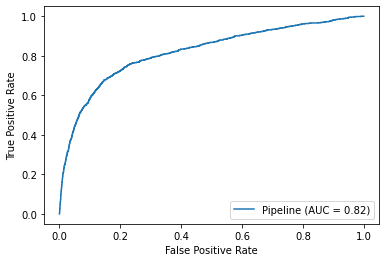

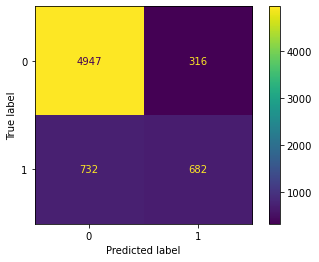

In [265]:
ModelWithCV(svm_pipe, 'final_model', X_test, y_test).print_summary()

 
  f1_score is 0.49015471167369906 CV Results for `knn` model:
            0.78628 ± 0.00483 accuracy
         <sklearn.metrics._plot.confusion_matrix.ConfusionMatrixDisplay object at 0x0000019C0BAB87C0> <sklearn.metrics._plot.roc_curve.RocCurveDisplay object at 0x0000019C77594FD0>


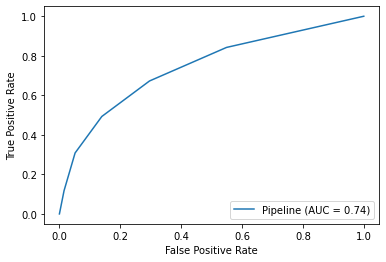

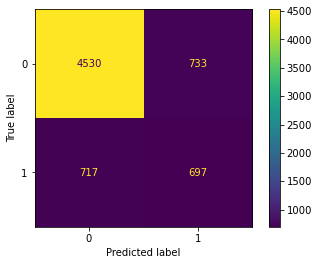

In [266]:
ModelWithCV(knn_pipe,'knn',X_test,y_test).print_summary()

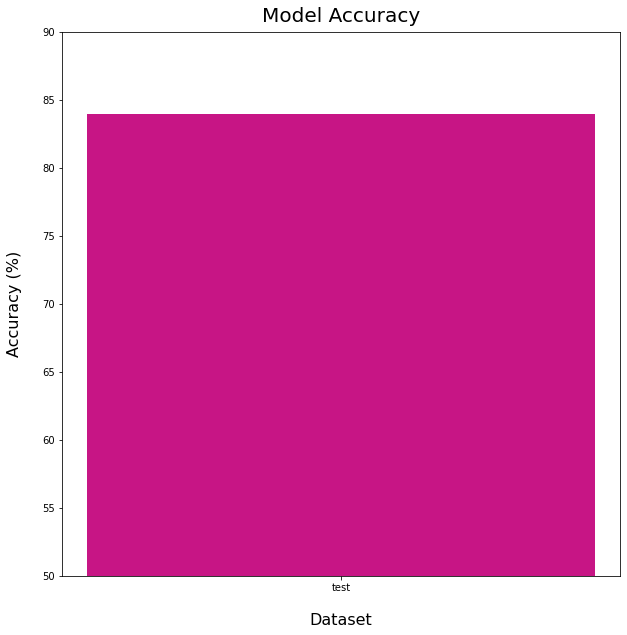

In [62]:
fig, ax = plt.subplots(figsize = (10,10))

X = ['test']
y =  [84]

ax.bar(X,height=y, color = ['mediumvioletred'])
        
ax.set_title('Model Accuracy', fontsize='20', pad=10)
ax.set_xlabel('Dataset', fontsize='16', labelpad=20)
ax.set_ylabel('Accuracy (%)', fontsize='16', labelpad=20)
ax.set_ylim([50, 90])

plt.savefig('finalmodel_accuracy.png', dpi = 200 )